# Parte 1: Construcción del Corpus

## Obtención de datos

### Instalamos librerías necesarias

In [ ]:
!pip install requests

### Importamos las librerías que usaremos

In [ ]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import random
from wordcloud import WordCloud
import os
import seaborn as sns

### Creamos una función para scrappear las noticias

In [ ]:

def extraer_articulo(url):
    try:
        response = requests.get(url, timeout=10)
        if response.status_code != 200:
            print(f"Error HTTP {response.status_code} en {url}")
            return None
        html = response.text
    except requests.exceptions.RequestException as e:
        print(f"Error de conexión en {url}: {e}")
        return None

    soup = BeautifulSoup(html, 'html.parser')

    # H1 y H2
    h1 = [tag.get_text(strip=True) for tag in soup.find_all('h1')]
    h2 = [tag.get_text(strip=True) for tag in soup.find_all('h2')]

    # Párrafos
    parrafos = [p.get_text(strip=True) for p in soup.find_all('p')]

    # Autor
    autor_tag = soup.find(class_=lambda c: c and 'author-name' in c)
    autor = autor_tag.get_text(strip=True) if autor_tag else None

    # Fecha
    fecha_tag = soup.find('time')
    fecha = fecha_tag.get_text(strip=True) if fecha_tag else None

    # Devolver como dict plano para DataFrame
    return {
        'titulo': h1[0] if h1 else '',
        'subtitulo': h2[0] if h2 else '',
        'fuente': 'Página 12',
        'fecha': fecha or '',
        'autor': autor or '',
        'parrafos': '\n\n'.join(parrafos)
    }

### Les asignamos las rutas a las variables creadas

In [ ]:
#URLs de Página 12

url_p12_01092025 = "https://www.pagina12.com.ar/853992-del-atentado-a-la-condena-de-la-corte-el-devenir-de-una-heri"
url_p12_02092025 = "https://www.pagina12.com.ar/854266-censura-y-allanamientos-la-arremetida-desesperada-de-los-mil"
url_p12_03092025 = "https://www.pagina12.com.ar/854460-la-segunda-muerte-del-plan-milei-caputo"
url_p12_04092025 = "https://www.pagina12.com.ar/854862-el-operativo-piedrazos-fracaso-y-milei-tuvo-un-cierre-de-cam"
url_p12_05092025 = "https://www.pagina12.com.ar/855169-un-cachetazo-historico-a-la-crueldad-y-el-agravio"
url_p12_06092025 = "https://www.pagina12.com.ar/855507-el-gobierno-se-sumio-en-un-todos-contra-todos-tras-la-crisis"

### Generamos un array de rutas

In [ ]:
urls_p12 = [url_p12_01092025, url_p12_02092025, url_p12_03092025, url_p12_04092025, url_p12_05092025, url_p12_06092025]

### Ponemos en uso la función creada con anterioridad

In [ ]:
articulos_extraidos = []
for url in urls_p12:
    articulo = extraer_articulo(url)
    if articulo:
        articulos_extraidos.append(articulo)

    # Espera entre 2 y 5 segundos (aleatoria)
    sleep_time = random.uniform(2, 5)
    print(f"Esperando {sleep_time:.2f} segundos antes de la siguiente solicitud...")
    time.sleep(sleep_time)

Esperando 4.86 segundos antes de la siguiente solicitud...


### Creamos un DataFrame con los artículos scrappeados

In [ ]:
df = pd.DataFrame(articulos_extraidos)

In [ ]:
df.head(1)

,titulo,subtitulo,fuente,fecha,autor,parrafos
0,Del atentado a la condena de la Corte: el deve...,El tercer aniversario del atentado encuentra a...,Página 12,1 de septiembre de 2025 - 00:13,PorIrina Hauser,EN VIVO\n\nTres años después de que intentaran...


### Trabajamos un poquito el DataFrame

trabajamos la fecha

In [ ]:
# Diccionario para mapear meses en español a números
meses = {
    'enero': '01',
    'febrero': '02',
    'marzo': '03',
    'abril': '04',
    'mayo': '05',
    'junio': '06',
    'julio': '07',
    'agosto': '08',
    'septiembre': '09',
    'octubre': '10',
    'noviembre': '11',
    'diciembre': '12'
}

# función para parsear fecha
def parse_fecha(fecha_str):
    try:
        # separar fecha y hora
        fecha_part, hora_part = fecha_str.split(' - ')

        # separar día, mes, año
        partes = fecha_part.split(' de ')
        dia = partes[0]
        mes = meses[partes[1].lower()]
        anio = partes[2]

        # armar string en formato ISO compatible
        fecha_iso = f"{anio}-{mes}-{dia} {hora_part}"

        # parsear con datetime
        return datetime.strptime(fecha_iso, '%Y-%m-%d %H:%M')
    except Exception as e:
        # si falla, devolver NaT
        return pd.NaT

# aplicamos la función a la columna 'fecha'
df['fecha'] = df['fecha'].apply(parse_fecha)

vemos como cambió el formato de la columna 'fecha'

In [ ]:
df.head(1)

,titulo,subtitulo,fuente,fecha,autor,parrafos
0,Del atentado a la condena de la Corte: el deve...,El tercer aniversario del atentado encuentra a...,Página 12,2025-09-01 00:13:00,PorIrina Hauser,EN VIVO\n\nTres años después de que intentaran...


agregamos columnas interesantes

In [ ]:
df['cantidad_parrafos'] = df['parrafos'].apply(lambda x: len(str(x).split('\n')))
df['cantidad_palabras'] = df['parrafos'].apply(lambda x: len(str(x).split()))
df['cantidad_caracteres'] = df['parrafos'].apply(lambda x: len(str(x)))

verificamos como quedo nuestro dataset

In [ ]:
df.head(1)

,titulo,subtitulo,fuente,fecha,autor,parrafos,cantidad_parrafos,cantidad_palabras,cantidad_caracteres
0,Del atentado a la condena de la Corte: el deve...,El tercer aniversario del atentado encuentra a...,Página 12,2025-09-01 00:13:00,PorIrina Hauser,EN VIVO\n\nTres años después de que intentaran...,35,2299,14030


observamos que "EN VIVO\n\n" se repite en todos los registros y debería ser algo a tratar en el próximo paso.

### Exportamos el DataFrame para poder guardarlo localmente

In [ ]:
df.to_csv("articulos_pagina12_comp.csv", index=False, encoding="utf-8")
from google.colab import files
files.download("articulos_pagina12_comp.csv")

### Sumamos datos recolectados de forma manual sobre otra fuente

montamos el drive para poder acceder a la carpeta que contienen a los .txt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


buscamos la ruta de la carpeta

In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/datasets/corpus/la nacion'

In [ ]:

def parsear_txt_con_parrafos(path):
    with open(path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    data = {}
    parrafos_flag = False
    parrafos_lines = []

    for line in lines:
        stripped = line.strip()

        if parrafos_flag:
            parrafos_lines.append(stripped)
        elif stripped.lower().startswith("parrafos:"):
            parrafos_flag = True
        elif ":" in line:
            key, value = line.split(":", 1)
            data[key.strip().lower()] = value.strip()

    if parrafos_lines:
        parrafos_texto = "\n\n".join(p for p in parrafos_lines if p != "")
        data["parrafos"] = parrafos_texto

    return data

def parsear_carpeta_txts(folder_path):
    datos = []

    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            filepath = os.path.join(folder_path, filename)
            try:
                dic = parsear_txt_con_parrafos(filepath)
                #dic['archivo'] = filename  # opcional: nombre del archivo
                datos.append(dic)
            except Exception as e:
                print(f"Error procesando {filename}: {e}")

    return pd.DataFrame(datos)


In [ ]:
folder_path = '/content/drive/MyDrive/Colab Notebooks/datasets/corpus/la nacion'
df = parsear_carpeta_txts(folder_path)

In [ ]:
df.head()

,titulo,subtitulo,fuente,fecha,autor,parrafos
0,"Milei respaldó a su hermana, llamó a votar el ...",El Presidente cerró la campaña bonaerense de L...,LA NACION,4 Sep 2025,Cecilia Devanna,"En medio de un fuerte operativo de seguridad, ..."
1,El Gobierno logró un fallo para impedir que se...,Lo decidió un juez civil y comercial; pidieron...,LA NACION,2 Sep 2025,Cecilia Devanna,En busca de superar la crisis por los audios a...
2,Arrasaba el oficialismo en Corrientes y el can...,"Juan Pablo Valdés, hermano del gobernador radi...",LA NACION,1 Sep 2025,Jaime Rosemberg,CORRIENTES (De un enviado especial).– El gober...
3,El Gobierno interviene para controlar el dólar...,GIRO. La entidad se desprendió de unos US$100 ...,LA NACION,3 Sep 2025,Javier Blanco,El Gobierno anunció ayer que empezaría a inter...
4,La oposición anuló por primera vez un veto de ...,"Con una amplia mayoría, el Senado dejó vigente...",LA NACION,5 Sep 2025,Delfina Celichini,La oposición se abroqueló ayer en el Senado pa...


### trabajamos un poquito este dataset

In [ ]:
def convertir_fecha(fecha_str):
    try:
        # Parsear la fecha desde formato "4 Sep 2025"
        fecha_obj = datetime.strptime(fecha_str, "%d %b %Y")
        # Formatear a "2025-09-04 00:00:00"
        return fecha_obj.strftime("%Y-%m-%d 00:00:00")
    except Exception:
        return None  # O lo que prefieras si hay error

In [ ]:
df['fecha'] = df['fecha'].apply(convertir_fecha)

In [ ]:
df.head(1)

,titulo,subtitulo,fuente,fecha,autor,parrafos
0,"Milei respaldó a su hermana, llamó a votar el ...",El Presidente cerró la campaña bonaerense de L...,LA NACION,2025-09-04 00:00:00,Cecilia Devanna,"En medio de un fuerte operativo de seguridad, ..."


In [ ]:
df['cantidad_parrafos'] = df['parrafos'].apply(lambda x: len(str(x).split('\n')))
df['cantidad_palabras'] = df['parrafos'].apply(lambda x: len(str(x).split()))
df['cantidad_caracteres'] = df['parrafos'].apply(lambda x: len(str(x)))

In [ ]:
df.head()

,titulo,subtitulo,fuente,fecha,autor,parrafos,cantidad_parrafos,cantidad_palabras,cantidad_caracteres
0,"Milei respaldó a su hermana, llamó a votar el ...",El Presidente cerró la campaña bonaerense de L...,LA NACION,2025-09-04 00:00:00,Cecilia Devanna,"En medio de un fuerte operativo de seguridad, ...",37,1155,7012
1,El Gobierno logró un fallo para impedir que se...,Lo decidió un juez civil y comercial; pidieron...,LA NACION,2025-09-02 00:00:00,Cecilia Devanna,En busca de superar la crisis por los audios a...,29,1108,7148
2,Arrasaba el oficialismo en Corrientes y el can...,"Juan Pablo Valdés, hermano del gobernador radi...",LA NACION,2025-09-01 00:00:00,Jaime Rosemberg,CORRIENTES (De un enviado especial).– El gober...,37,1105,6902
3,El Gobierno interviene para controlar el dólar...,GIRO. La entidad se desprendió de unos US$100 ...,LA NACION,2025-09-03 00:00:00,Javier Blanco,El Gobierno anunció ayer que empezaría a inter...,29,997,5920
4,La oposición anuló por primera vez un veto de ...,"Con una amplia mayoría, el Senado dejó vigente...",LA NACION,2025-09-05 00:00:00,Delfina Celichini,La oposición se abroqueló ayer en el Senado pa...,43,1111,6968


In [ ]:
df.to_csv("articulos_lanacion_comp.csv", index=False, encoding="utf-8")
from google.colab import files
files.download("articulos_lanacion_comp.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
ruta_df_p12 = "/content/drive/MyDrive/Colab Notebooks/datasets/articulos_pagina12_comp.csv"
ruta_df_lanacion = "/content/drive/MyDrive/Colab Notebooks/datasets/articulos_lanacion_comp.csv"

In [ ]:
df_p12 = pd.read_csv(ruta_df_p12)
df_lanacion = pd.read_csv(ruta_df_lanacion)

In [ ]:
df_final = pd.concat([df_p12, df_lanacion], ignore_index=True)

In [ ]:
df_final.sample(5)

,titulo,subtitulo,fuente,fecha,autor,parrafos,cantidad_parrafos,cantidad_palabras,cantidad_caracteres
11,"Para contener el dólar antes de la elección, v...",La cifra surge de una estimación del mercado; ...,LA NACION,2025-09-06 00:00:00,Javier Blanco,"En la previa electoral, el Gobierno logró impo...",31,1012,5964
1,Censura y allanamientos: la arremetida desespe...,Deriva autoritaria del Gobierno frente al escá...,Página 12,2025-09-02 07:19:00,NaN,EN VIVO\n\nEl gobierno de Javier Milei salió a...,41,1669,10119
6,"Milei respaldó a su hermana, llamó a votar el ...",El Presidente cerró la campaña bonaerense de L...,LA NACION,2025-09-04 00:00:00,Cecilia Devanna,"En medio de un fuerte operativo de seguridad, ...",37,1155,7012
3,El operativo piedrazos fracasó y Milei tuvo un...,El Presidente fue a Moreno para buscar violenc...,Página 12,2025-09-04 15:45:00,PorMelisa Molina,EN VIVO\n\nEn medio del escándalo por las coim...,33,1330,8123
2,La segunda muerte del plan Milei-Caputo,"Atemorizado por la escalada de dólar, el Gobie...",Página 12,2025-09-03 00:01:00,PorLeandro Renou,"EN VIVO\n\nEn marzo de este año, estrangulado ...",29,1390,8140


# Parte 2: Análisis Técnico - Estructura del Notebook

## Sección 1: Presentación del Corpus

### Título: "Análisis de Noticias Políticas: Se repiten las mismas noticias antes de las elecciones"


### 1.1 Descripción del corpus elegido

- Qué tipo de textos incluye: Noticias políticas Argentinas
- Cuántos documentos: 12
- Período temporal abarcado: 01/09 al 06/09 2025
- Fuentes utilizadas: Página 12, La nación

### 1.2 Justificación de la elección

- Por qué elegiste este corpus: porque me pintó
- Qué te interesa descubrir: si es todo lo mismo
- Qué hipótesis tenés sobre lo que vas a encontrar: que si

### 1.3 Proceso de recolección

- Cómo obtuviste los textos: scrapping
- Criterios de inclusión/exclusión: días previos a las elecciones
- Dificultades encontradas y cómo las resolviste: como sergmentar esos días

### 1.4 Estadísticas básicas

- Número total de textos:

In [ ]:
df_final.shape[0]

12

- Número total de palabras (aproximado):

In [ ]:
df_final['cantidad_palabras'].sum()

np.int64(16096)

- Distribución de tamaños de documentos

In [ ]:
# Convertir a datetime
df_final['fecha'] = pd.to_datetime(df_final['fecha'], errors='coerce')

# Crear columna sin hora
df_final['fecha_sin_hora'] = df_final['fecha'].dt.date

# Agrupar por fecha sin hora y sumar palabras
df_agrupado = df_final.groupby('fecha_sin_hora')['cantidad_palabras'].sum().reset_index()


/tmp/ipython-input-3771251580.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


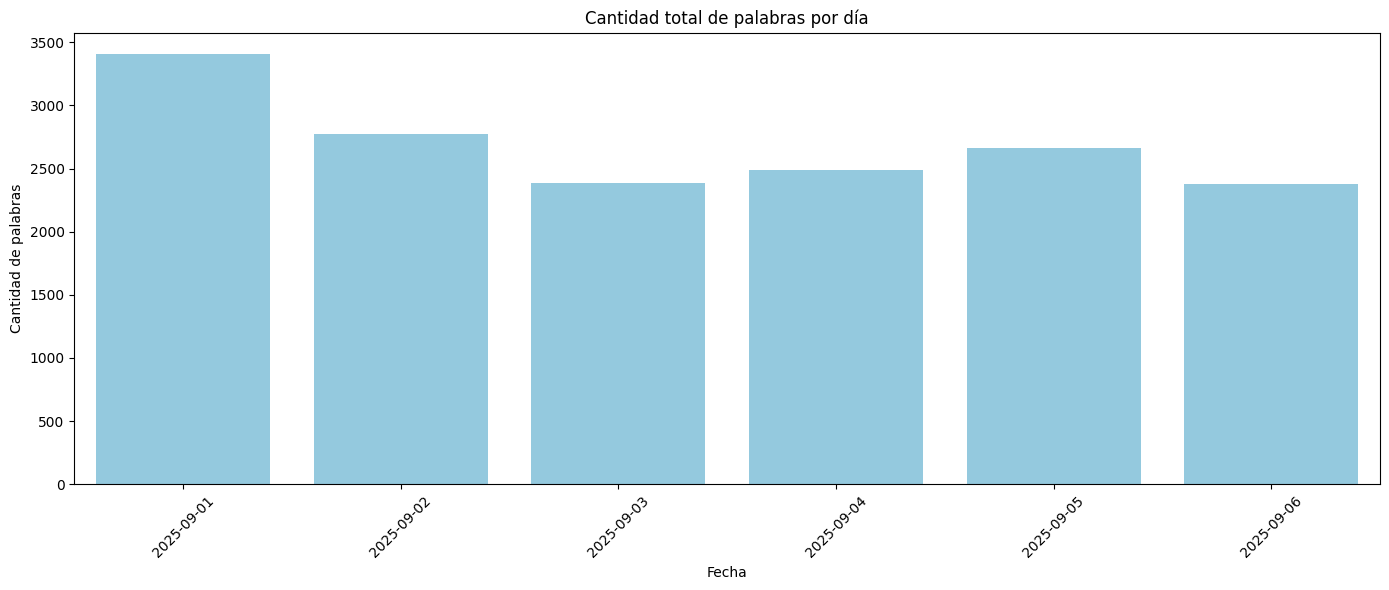

In [ ]:
plt.figure(figsize=(14, 6))
sns.barplot(
    x='fecha_sin_hora',
    y='cantidad_palabras',
    data=df_agrupado,
    color='skyblue',
    ci=None
)
plt.title('Cantidad total de palabras por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de palabras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- Gráfico de distribución temporal (si aplicable)

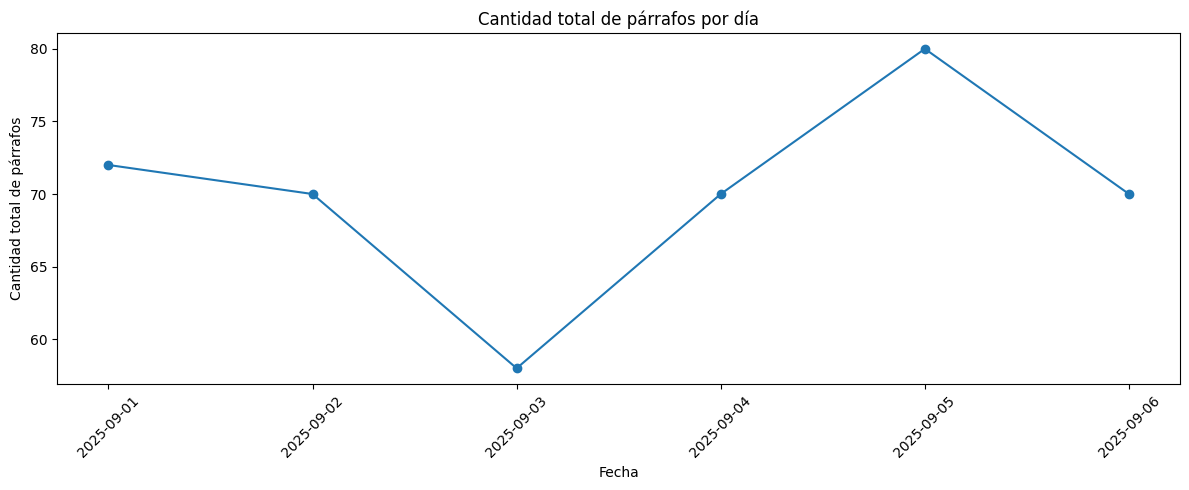

In [ ]:
# Agrupar por fecha sin hora
parrafos_por_fecha = df_final.groupby('fecha_sin_hora')['cantidad_parrafos'].sum().sort_index()

# Graficar
plt.figure(figsize=(12, 5))
plt.plot(parrafos_por_fecha.index, parrafos_por_fecha.values, marker='o')
plt.title('Cantidad total de párrafos por día')
plt.xlabel('Fecha')
plt.ylabel('Cantidad total de párrafos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_final.to_csv("df_articulos_final.csv", index=False, encoding="utf-8")
from google.colab import files
files.download("df_articulos_final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 1.5 Exploración inicial

- Mostrar fragmentos representativos:

In [ ]:
def longitud_parrafo_mas_largo(parrafos_str):
    parrafos = parrafos_str.split('\n\n')
    return max((len(p.split()) for p in parrafos), default=0)  # mide por palabras

df_final['largo_parrafo_max'] = df_final['parrafos'].apply(longitud_parrafo_mas_largo)

In [ ]:
top_largos = df_final.sort_values('largo_parrafo_max', ascending=False).head(3)

for i, row in top_largos.iterrows():
    parrafos = row['parrafos'].split('\n\n')
    parrafo_mas_largo = max(parrafos, key=lambda p: len(p.split()))  # por palabras

    print(f"--- Título: {row['titulo']} ---")
    print(f"Párrafo más largo (palabras): {len(parrafo_mas_largo.split())}")
    print("Párrafo:")
    print(parrafo_mas_largo)
    print("\n" + "="*80 + "\n")

--- Título: Censura y allanamientos: la arremetida desesperada de los Milei para tapar los audios de las coimas ---
Párrafo más largo (palabras): 234
Párrafo:
El gobierno de Javier Milei salió a silenciar y perseguir periodistas para tapar el escándalo de las coimas en Discapacidad y la feroz interna libertaria que dio origen a los audios de la  corrupción.Censura previa, pura y dura. A través de dos denuncias, una penal y otra civil, el gobierno libertario pidió allanamientos a comunicadores y abogadoscon el insólito argumento de que se trata de un complot urdido por el kirchnerismo con influencia rusa, venezolana, boliviana y hasta de la Asociación del Fútbol Argentino (AFA).En las 20 páginas de la denuncia penal no se menciona a Diego Spagnuolo ni aparecen las palabras coimas o medicamentos para discapacitados con “el 3 por ciento para Karina”. Menos aún se menciona a los libertarios que evidentemente grabaron los audios, dado que unos se originaron en la Casa Rosada -lugar al que n

In [ ]:
top_cortos = df_final.sort_values('largo_parrafo_max', ascending=True).head(3)

for i, row in top_cortos.iterrows():
    parrafos = row['parrafos'].split('\n\n')
    parrafo_mas_largo = max(parrafos, key=lambda p: len(p.split()))  # por palabras

    print(f"--- Título: {row['titulo']} ---")
    print(f"Párrafo más corto (palabras): {len(parrafo_mas_largo.split())}")
    print("Párrafo:")
    print(parrafo_mas_largo)
    print("\n" + "="*80 + "\n")

--- Título: La oposición anuló por primera vez un veto de Milei y va contra los DNU ---
Párrafo más corto (palabras): 100
Párrafo:
Durante las cuestiones de privilegio, Mayans hizo un repaso de la polémica que atraviesa al Poder Ejecutivo y anticipó otra jugada: la posibilidad de impulsar el juicio político contra la ministra de Seguridad, Patricia Bullrich, por la denuncia que solicita allanamientos a periodistas que difundieron audios atribuidos a Karina Milei. “Sin importar el color político, tenemos que hablar con nuestros representantes en Diputados y acá tiene que acusar la Cámara de Diputados ante el Senado de la Nación a la ministra Bullrich por este disparatado acto y por falsa denuncia poniendo en alerta todo el sistema de seguridad nacional”, dictaminó.ß


--- Título: El Gobierno logró un fallo para impedir que se difundan más audios de Karina Milei ---
Párrafo más corto (palabras): 101
Párrafo:
Un juez federal en lo civil y comercial ordenó ayer, a pedido del Poder Ejecutiv

- Primeras observaciones cualitativas:

In [ ]:
# COMPLETAR

- Nube de palabras inicial (opcional):

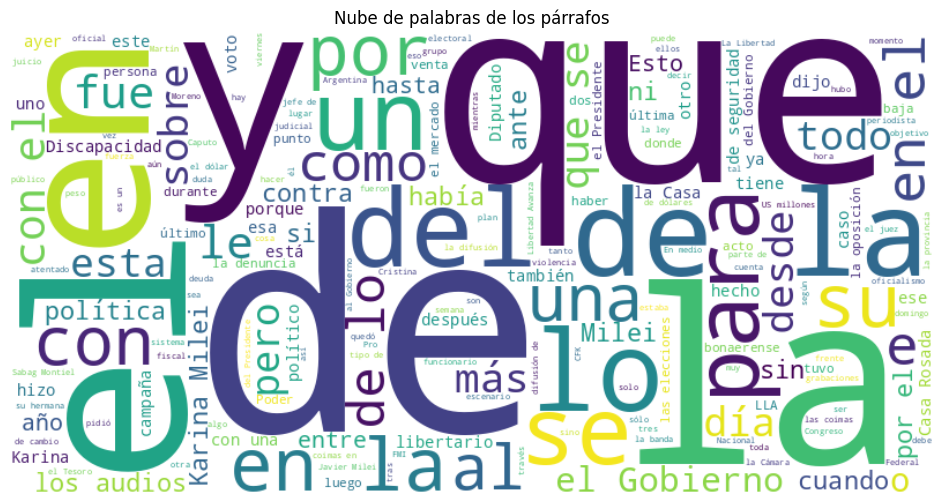

In [ ]:
# Unir todos los textos
texto_completo = ' '.join(df_final['parrafos'].dropna().astype(str).tolist())

# Crear nube
nube = WordCloud(width=800, height=400, background_color='white').generate(texto_completo)

# Mostrar
plt.figure(figsize=(12, 6))
plt.imshow(nube, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de los párrafos')
plt.show()


## Sección 2: Preprocesamiento

### 2.1 Carga y organización de datos

In [5]:
import pandas as pd
import numpy as np
import pickle
import re
import string
from collections import Counter

- Código para cargar todos los archivos de texto

In [3]:
ruta = "/content/drive/MyDrive/Colab Notebooks/datasets/df_articulos_final.csv"
df_completo = pd.read_csv(ruta)
textos = df_completo['parrafos'].tolist()

In [ ]:
textos[0]

'EN VIVO\n\nTres años después de que intentaran matarla, la frase de Cristina Fernández de Kirchner "me quieren presa o muerta" se hizo carne. La había pronunciado después de recibir la condena del Tribunal Oral Federal 2 en el caso "Vialidad" (seis años de prisión e inhabilitación perpetua para ejercer cargos públicos), que llegó tres meses después del intento de magnicidio.Lo que no pudo la bala con la que quiso asesinarla Fernando Sabag Montiel es a lo que trató de acercarse la Corte Supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en Santa Cruz inspirado en la máxima de estos tiempos: "no podía no saber". Despojarla de sus derechos políticos, borrarla de la escena política, de eso se trata. Es la coranación de lo que algunos llamanlawfare, aunque otros prefieren hablar del uso del sistema de justicia por parte del político, económico y, habría que agregar, geopolítico. Como se lo llame, tiene algo 

- Integración con metadatos

- Verificación de integridad de datos

### 2.2 Limpieza de texto

- Aplicar técnicas vistas en clase:

In [5]:
textos_limpios = [t.replace('\xa0', '') for t in textos]
textos_limpios = [t.replace('EN VIVO\n\n', '') for t in textos]

In [ ]:
textos_limpios[0]

'Tres años después de que intentaran matarla, la frase de Cristina Fernández de Kirchner "me quieren presa o muerta" se hizo carne. La había pronunciado después de recibir la condena del Tribunal Oral Federal 2 en el caso "Vialidad" (seis años de prisión e inhabilitación perpetua para ejercer cargos públicos), que llegó tres meses después del intento de magnicidio.Lo que no pudo la bala con la que quiso asesinarla Fernando Sabag Montiel es a lo que trató de acercarse la Corte Supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en Santa Cruz inspirado en la máxima de estos tiempos: "no podía no saber". Despojarla de sus derechos políticos, borrarla de la escena política, de eso se trata. Es la coranación de lo que algunos llamanlawfare, aunque otros prefieren hablar del uso del sistema de justicia por parte del político, económico y, habría que agregar, geopolítico. Como se lo llame, tiene algo en común co

In [ ]:
#   * Conversión a minúsculas

In [6]:
textos_minuscula = [texto.lower() for texto in textos_limpios]

In [ ]:
textos_minuscula[0]

'tres años después de que intentaran matarla, la frase de cristina fernández de kirchner "me quieren presa o muerta" se hizo carne. la había pronunciado después de recibir la condena del tribunal oral federal 2 en el caso "vialidad" (seis años de prisión e inhabilitación perpetua para ejercer cargos públicos), que llegó tres meses después del intento de magnicidio.lo que no pudo la bala con la que quiso asesinarla fernando sabag montiel es a lo que trató de acercarse la corte supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en santa cruz inspirado en la máxima de estos tiempos: "no podía no saber". despojarla de sus derechos políticos, borrarla de la escena política, de eso se trata. es la coranación de lo que algunos llamanlawfare, aunque otros prefieren hablar del uso del sistema de justicia por parte del político, económico y, habría que agregar, geopolítico. como se lo llame, tiene algo en común co

In [7]:
#   * Eliminación de signos de puntuación

In [8]:
textos_sin_puntuacion = [
    texto.translate(str.maketrans('', '', string.punctuation))
    for texto in textos_minuscula
]

In [ ]:
textos_sin_puntuacion[0]

'tres años después de que intentaran matarla la frase de cristina fernández de kirchner me quieren presa o muerta se hizo carne la había pronunciado después de recibir la condena del tribunal oral federal 2 en el caso vialidad seis años de prisión e inhabilitación perpetua para ejercer cargos públicos que llegó tres meses después del intento de magnicidiolo que no pudo la bala con la que quiso asesinarla fernando sabag montiel es a lo que trató de acercarse la corte supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en santa cruz inspirado en la máxima de estos tiempos no podía no saber despojarla de sus derechos políticos borrarla de la escena política de eso se trata es la coranación de lo que algunos llamanlawfare aunque otros prefieren hablar del uso del sistema de justicia por parte del político económico y habría que agregar geopolítico como se lo llame tiene algo en común con el atentado a cfk que

In [ ]:
#   * Eliminación de números (si no son relevantes)

In [9]:
textos_sin_numeros = [re.sub(r'\d+', '', texto) for texto in textos_sin_puntuacion]

In [10]:
textos_sin_numeros[0]

'tres años después de que intentaran matarla la frase de cristina fernández de kirchner me quieren presa o muerta se hizo carne la había pronunciado después de recibir la condena del tribunal oral federal  en el caso vialidad seis años de prisión e inhabilitación perpetua para ejercer cargos públicos que llegó tres meses después del intento de magnicidiolo que no pudo la bala con la que quiso asesinarla fernando sabag montiel es a lo que trató de acercarse la corte supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en santa cruz inspirado en la máxima de estos tiempos no podía no saber despojarla de sus derechos políticos borrarla de la escena política de eso se trata es la coranación de lo que algunos llamanlawfare aunque otros prefieren hablar del uso del sistema de justicia por parte del político económico y habría que agregar geopolítico como se lo llame tiene algo en común con el atentado a cfk que 

In [ ]:
#   * Eliminación de caracteres especiales

In [11]:
textos_sin_especiales = [re.sub(r'[^a-z0-9ñáéíóú\s]', '', t) for t in textos_sin_numeros]

In [ ]:
textos_sin_especiales[0]

'tres años después de que intentaran matarla la frase de cristina fernández de kirchner me quieren presa o muerta se hizo carne la había pronunciado después de recibir la condena del tribunal oral federal  en el caso vialidad seis años de prisión e inhabilitación perpetua para ejercer cargos públicos que llegó tres meses después del intento de magnicidiolo que no pudo la bala con la que quiso asesinarla fernando sabag montiel es a lo que trató de acercarse la corte supremaal confirmar la decisión de aquel tribunal que la acusó sin pruebas por el direccionamiento y por sobreprecios en obras viales en santa cruz inspirado en la máxima de estos tiempos no podía no saber despojarla de sus derechos políticos borrarla de la escena política de eso se trata es la coranación de lo que algunos llamanlawfare aunque otros prefieren hablar del uso del sistema de justicia por parte del político económico y habría que agregar geopolítico como se lo llame tiene algo en común con el atentado a cfk que 

In [12]:
df_completo['parrafos_limpios'] = textos_sin_especiales

In [13]:
df_completo.to_csv("/content/drive/MyDrive/Colab Notebooks/datasets/df_articulos_limpio.csv", index=False)

In [ ]:
# Guardar en archivo .pkl
with open('textos_limpios.pkl', 'wb') as f:
    pickle.dump(textos_sin_especiales, f)

In [ ]:
from google.colab import files
files.download('textos_limpios.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

- Justificar cada decisión de limpieza

In [ ]:
# esto va a ser texto

### 2.3 Tokenización y normalización

In [2]:
!pip install -U spacy
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 64.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Abrir el archivo y cargar la lista
ruta = "/content/drive/MyDrive/Colab Notebooks/datasets/textos_limpios.pkl"
with open(ruta, 'rb') as f:
    textos_limpios = pickle.load(f)

In [9]:
ruta = "/content/drive/MyDrive/Colab Notebooks/datasets/df_articulos_limpio.csv"
df_completo = pd.read_csv(ruta)
textos_limpios = df_completo['parrafos_limpios'].tolist()

In [3]:
import spacy
nlp = spacy.load("es_core_news_sm")  # Modelo en español

In [ ]:
def tokenizar_normalizar_spacy(texto):
    doc = nlp(texto)
    tokens = []
    for token in doc:
        if not token.is_punct and not token.is_space and not token.is_digit:
            token_texto = token.text.lower()
            tokens.append(token_texto)
    return tokens

- Separar texto en palabras

In [ ]:
tokens_por_texto = [tokenizar_normalizar_spacy(texto) for texto in textos_limpios]

In [ ]:
tokens_por_texto[0]

['tres',
 'años',
 'después',
 'de',
 'que',
 'intentaran',
 'matarla',
 'la',
 'frase',
 'de',
 'cristina',
 'fernández',
 'de',
 'kirchner',
 'me',
 'quieren',
 'presa',
 'o',
 'muerta',
 'se',
 'hizo',
 'carne',
 'la',
 'había',
 'pronunciado',
 'después',
 'de',
 'recibir',
 'la',
 'condena',
 'del',
 'tribunal',
 'oral',
 'federal',
 'en',
 'el',
 'caso',
 'vialidad',
 'seis',
 'años',
 'de',
 'prisión',
 'e',
 'inhabilitación',
 'perpetua',
 'para',
 'ejercer',
 'cargos',
 'públicos',
 'que',
 'llegó',
 'tres',
 'meses',
 'después',
 'del',
 'intento',
 'de',
 'magnicidio',
 'lo',
 'que',
 'no',
 'pudo',
 'la',
 'bala',
 'con',
 'la',
 'que',
 'quiso',
 'asesinarla',
 'fernando',
 'sabag',
 'montiel',
 'es',
 'a',
 'lo',
 'que',
 'trató',
 'de',
 'acercarse',
 'la',
 'corte',
 'supremaal',
 'confirmar',
 'la',
 'decisión',
 'de',
 'aquel',
 'tribunal',
 'que',
 'la',
 'acusó',
 'sin',
 'pruebas',
 'por',
 'el',
 'direccionamiento',
 'y',
 'por',
 'sobreprecios',
 'en',
 'obras',


- Decidir si aplicar stemming o lemmatización (justificar)

In [10]:
def lematizar_spacy(texto):
    doc = nlp(texto)
    lemas = [
        token.lemma_.lower()
        for token in doc
        if not token.is_punct and not token.is_space and not token.is_digit
    ]
    return lemas


In [11]:
lemas_por_texto = [lematizar_spacy(t) for t in textos_limpios]

In [12]:
lemas_por_texto[0]

['tres',
 'año',
 'después',
 'de',
 'que',
 'intentar',
 'matar él',
 'el',
 'frase',
 'de',
 'cristina',
 'fernández',
 'de',
 'kirchner',
 'yo',
 'querer',
 'presa',
 'o',
 'muerto',
 'él',
 'hacer',
 'carne',
 'él',
 'haber',
 'pronunciar',
 'después',
 'de',
 'recibir',
 'el',
 'condena',
 'del',
 'tribunal',
 'oral',
 'federal',
 'en',
 'el',
 'caso',
 'vialidad',
 'seis',
 'año',
 'de',
 'prisión',
 'e',
 'inhabilitación',
 'perpetuo',
 'para',
 'ejercer',
 'cargo',
 'público',
 'que',
 'llegar',
 'tres',
 'mes',
 'después',
 'del',
 'intento',
 'de',
 'magnicidio él',
 'que',
 'no',
 'poder',
 'el',
 'bala',
 'con',
 'el',
 'que',
 'querer',
 'asesinar él',
 'fernando',
 'sabag',
 'montiel',
 'ser',
 'a',
 'él',
 'que',
 'tratar',
 'de',
 'acercar él',
 'el',
 'corte',
 'supremaal',
 'confirmar',
 'el',
 'decisión',
 'de',
 'aquel',
 'tribunal',
 'que',
 'él',
 'acusar',
 'sin',
 'prueba',
 'por',
 'el',
 'direccionamiento',
 'y',
 'por',
 'sobreprecio',
 'en',
 'obra',
 'vial'

- Mostrar ejemplos de antes y después

In [ ]:
print(f"{'Token':<15} {'Lema':<15}")
print("-" * 30)
for token, lema in zip(tokens_por_texto[0], lemas_por_texto[0]):
    print(f"{token:<15} {lema:<15}")


Token           Lema           
------------------------------
tres            tres           
años            año            
después         después        
de              de             
que             que            
intentaran      intentar       
matarla         matar él       
la              el             
frase           frase          
de              de             
cristina        cristina       
fernández       fernández      
de              de             
kirchner        kirchner       
me              yo             
quieren         querer         
presa           presa          
o               o              
muerta          muerto         
se              él             
hizo            hacer          
carne           carne          
la              el             
había           haber          
pronunciado     pronunciar     
después         después        
de              de             
recibir         recibir        
la              el             
condena  

### 2.4 Manejo de stop words

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

- Decidir qué stop words usar (español estándar + específicas del dominio)

In [14]:
from nltk.corpus import stopwords

stopwords_es = set(stopwords.words('spanish'))

- Mostrar impacto de eliminar stop words

In [15]:
textos_filtrados = [
    [lema for lema in texto if lema not in stopwords_es]
    for texto in lemas_por_texto
]

In [ ]:
textos_filtrados[0]

['tres',
 'año',
 'después',
 'intentar',
 'matar él',
 'frase',
 'cristina',
 'fernández',
 'kirchner',
 'querer',
 'presa',
 'muerto',
 'hacer',
 'carne',
 'haber',
 'pronunciar',
 'después',
 'recibir',
 'condena',
 'tribunal',
 'oral',
 'federal',
 'caso',
 'vialidad',
 'seis',
 'año',
 'prisión',
 'inhabilitación',
 'perpetuo',
 'ejercer',
 'cargo',
 'público',
 'llegar',
 'tres',
 'mes',
 'después',
 'intento',
 'magnicidio',
 'poder',
 'bala',
 'querer',
 'asesinar él',
 'fernando',
 'sabag',
 'montiel',
 'ser',
 'tratar',
 'acercar él',
 'corte',
 'supremaal',
 'confirmar',
 'decisión',
 'aquel',
 'tribunal',
 'acusar',
 'prueba',
 'direccionamiento',
 'sobreprecio',
 'obra',
 'vial',
 'santa',
 'cruz',
 'inspirado',
 'máximo',
 'tiempo',
 'poder',
 'saber',
 'despojarla',
 'derecho',
 'político',
 'borrar él',
 'escena',
 'político',
 'tratar',
 'ser',
 'coranación',
 'alguno',
 'llamanlawfarir',
 'aunque',
 'preferir',
 'hablar',
 'uso',
 'sistema',
 'justicia',
 'parte',
 'p

- Justificar decisiones

### 2.5 Estadísticas post-procesamiento

- Vocabulario final (número de palabras únicas)

In [ ]:
# Unir todas las listas en una sola lista con todos los tokens
todos_los_tokens = [token for texto in textos_filtrados for token in texto]

# Obtener el conjunto (set) de palabras únicas
vocabulario_unico = set(todos_los_tokens)

# Cantidad de palabras únicas
cantidad_vocabulario = len(vocabulario_unico)

print(f"Vocabulario final (palabras únicas): {cantidad_vocabulario}")


Vocabulario final (palabras únicas): 2929


In [ ]:
print("Ejemplos de palabras únicas:", list(vocabulario_unico)[:20])


Ejemplos de palabras únicas: ['matar él', 'emergencia', 'publicación', 'herido', 'financiar', 'ubicado', '0,3%', 'crawling-peg', 'decreto', 'roto', 'revisión', 'interés', 'vegas', 'troll', 'retorno', 'unánime', 'oposición', 'chaco', 'san', 'dolarización']


- Distribución de frecuencias

In [ ]:
# Unir todos los tokens en una sola lista
todos_los_tokens = [token for texto in textos_filtrados for token in texto]

# Crear un contador de frecuencias
frecuencias = Counter(todos_los_tokens)


In [ ]:
print(frecuencias.most_common(10))


[('ser', 187), ('haber', 93), ('milei', 69), ('hacer', 66), ('poder', 64), ('gobierno', 63), ('tener', 57), ('decir', 43), ('karina', 43), ('audio', 41)]


- Comparación antes/después del preprocesamiento

In [ ]:
for original, procesado in zip(textos, textos_filtrados):
    print(f"Antes:    {original[:30]}")  # primeros 30 caracteres del texto original
    print(f"Después:  {' '.join(procesado)[:30]}")  # primeros 30 caracteres del texto procesado unido
    print("-" * 50)



Antes:    EN VIVO

Tres años después de 
Después:  tres año después intentar mata
--------------------------------------------------
Antes:    EN VIVO

El gobierno de Javier
Después:  gobierno javier milei salir si
--------------------------------------------------
Antes:    EN VIVO

En marzo de este año,
Después:  marzo año estrangulado falta d
--------------------------------------------------
Antes:    EN VIVO

En medio del escándal
Después:  medio escándalo coima agencia 
--------------------------------------------------
Antes:    EN VIVO

El Gobierno tuvo otro
Después:  gobierno tener jueves negro se
--------------------------------------------------
Antes:    EN VIVO

Javier Milei se refug
Después:  javier milei refugiar unidos b
--------------------------------------------------
Antes:    En medio de un fuerte operativ
Después:  medio fuerte operativo segurid
--------------------------------------------------
Antes:    En busca de superar la crisis 
Después:  busca superar cris

## Sección 3: Análisis con BoW/TF-IDF (25% de la nota)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

### 3.1 Vectorización del corpus

In [ ]:
vectorizer = CountVectorizer()

- Crear matriz documento-término con CountVectorizer

In [ ]:
textos_para_vectorizar = [' '.join(texto) for texto in textos_filtrados]


In [ ]:
matriz_bow = vectorizer.fit_transform(textos_para_vectorizar)


In [ ]:
vocabulario = vectorizer.get_feature_names_out()
print(f"Número de términos: {len(vocabulario)}")
print("Algunos términos:", vocabulario[:10])


Número de términos: 2865
Algunos términos: ['00' '04' '08' '12asumeír' '16' '18' '20' '2000' '2023' '2025']


In [ ]:
import pandas as pd

df_bow = pd.DataFrame(matriz_bow.toarray(), columns=vocabulario)
print(df_bow.head())


   00  04  08  12asumeír  16  18  20  2000  2023  2025  ...  área  él  éxito  \
0   0   0   0          1   0   0   0     0     0     0  ...     0  14      1   
1   0   0   0          1   0   0   0     1     0     0  ...     0   4      0   
2   0   0   0          1   0   0   0     0     0     0  ...     0   6      0   
3   0   0   0          1   0   0   0     0     0     0  ...     0   7      0   
4   0   0   0          1   0   0   0     0     1     0  ...     0   9      0   

   ícono  íntimo  óptimo  órden  último  únicamente  único  
0      0       0       0      0       5           0      0  
1      0       0       0      1       0           1      0  
2      1       0       0      0       6           0      1  
3      0       0       1      0       3           0      0  
4      0       0       0      0       1           0      1  

[5 rows x 2865 columns]


- Crear matriz TF-IDF

In [ ]:
textos_para_vectorizar = [' '.join(texto) for texto in textos_filtrados]

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
matriz_tfidf = tfidf_vectorizer.fit_transform(textos_para_vectorizar)

vocabulario = tfidf_vectorizer.get_feature_names_out()
print(f"Número de términos: {len(vocabulario)}")
print("Algunos términos:", vocabulario[:10])

import pandas as pd
df_tfidf = pd.DataFrame(matriz_tfidf.toarray(), columns=vocabulario)
print(df_tfidf.head())


Número de términos: 2865
Algunos términos: ['00' '04' '08' '12asumeír' '16' '18' '20' '2000' '2023' '2025']
    00   04   08  12asumeír   16   18   20      2000      2023  2025  ...  \
0  0.0  0.0  0.0   0.011909  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
1  0.0  0.0  0.0   0.016697  0.0  0.0  0.0  0.029617  0.000000   0.0  ...   
2  0.0  0.0  0.0   0.017354  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
3  0.0  0.0  0.0   0.020460  0.0  0.0  0.0  0.000000  0.000000   0.0  ...   
4  0.0  0.0  0.0   0.016813  0.0  0.0  0.0  0.000000  0.029823   0.0  ...   

   área        él     éxito     ícono  íntimo    óptimo     órden    último  \
0   0.0  0.111224  0.018142  0.000000     0.0  0.000000  0.000000  0.042923   
1   0.0  0.044554  0.000000  0.000000     0.0  0.000000  0.025435  0.000000   
2   0.0  0.069461  0.000000  0.030783     0.0  0.000000  0.000000  0.075057   
3   0.0  0.095542  0.000000  0.000000     0.0  0.036292  0.000000  0.044246   
4   0.0  0.100942  0.000000  0.000

- Mostrar dimensiones y características de las matrices

In [ ]:
print("Dimensiones de la matriz BoW:", matriz_bow.shape)
print("Dimensiones de la matriz TF-IDF:", matriz_tfidf.shape)


Dimensiones de la matriz BoW: (12, 2865)
Dimensiones de la matriz TF-IDF: (12, 2865)


In [ ]:
n_docs_bow, n_terms_bow = matriz_bow.shape
n_docs_tfidf, n_terms_tfidf = matriz_tfidf.shape

print(f"BoW - Documentos: {n_docs_bow}, Términos: {n_terms_bow}")
print(f"TF-IDF - Documentos: {n_docs_tfidf}, Términos: {n_terms_tfidf}")


BoW - Documentos: 12, Términos: 2865
TF-IDF - Documentos: 12, Términos: 2865


In [ ]:
def sparsity(matrix):
    total_elements = matrix.shape[0] * matrix.shape[1]
    nonzero_elements = matrix.count_nonzero()
    zero_elements = total_elements - nonzero_elements
    return zero_elements / total_elements

print(f"Sparsity BoW: {sparsity(matriz_bow):.4f}")  # Ej: 0.95 = 95% ceros
print(f"Sparsity TF-IDF: {sparsity(matriz_tfidf):.4f}")


Sparsity BoW: 0.8417
Sparsity TF-IDF: 0.8417


In [ ]:
import numpy as np

print("Ejemplo fila 0, matriz BoW:", matriz_bow[0].toarray())
print("Ejemplo fila 0, matriz TF-IDF:", matriz_tfidf[0].toarray())


Ejemplo fila 0, matriz BoW: [[0 0 0 ... 5 0 0]]
Ejemplo fila 0, matriz TF-IDF: [[0.         0.         0.         ... 0.04292298 0.         0.        ]]


- Explicar qué representan los números

En BoW, cada número es la cantidad de veces que una palabra aparece en un documento.

En TF-IDF, cada número es un peso que mide la importancia de esa palabra en el documento, considerando su frecuencia y rareza en todo el corpus.

### 3.2 Términos más frecuentes y distintivos

- Top 20 palabras más frecuentes (BoW)

In [ ]:
from collections import Counter
import numpy as np

# Suponiendo que ya tenés la matriz BoW y el vocabulario
# matriz_bow: matriz documento-término (sparse)
# vocabulario: lista de términos (palabras)

# Sumar la frecuencia de cada término en todos los documentos
frecuencias = np.array(matriz_bow.sum(axis=0)).flatten()

# Crear lista de (palabra, frecuencia)
palabras_frecuencias = list(zip(vocabulario, frecuencias))

# Ordenar de mayor a menor frecuencia
palabras_frecuencias = sorted(palabras_frecuencias, key=lambda x: x[1], reverse=True)

# Mostrar las top 20
top_20 = palabras_frecuencias[:20]

for palabra, freq in top_20:
    print(f"{palabra}: {freq}")


ser: 187
haber: 93
milei: 71
hacer: 67
él: 65
poder: 64
gobierno: 63
tener: 57
decir: 44
karina: 43
audio: 41
día: 40
presidente: 36
político: 32
ir: 30
discapacidad: 28
denuncia: 27
libertario: 27
último: 27
elección: 26


- Top 20 términos con mayor TF-IDF

In [ ]:
import numpy as np

# Suponiendo que ya tenés:
# matriz_tfidf (documento-término)
# vocabulario (lista de términos)

# Sumar TF-IDF por columna (por término)
suma_tfidf = np.array(matriz_tfidf.sum(axis=0)).flatten()

# Crear lista (palabra, suma_tf-idf)
palabras_tfidf = list(zip(vocabulario, suma_tfidf))

# Ordenar de mayor a menor TF-IDF total
palabras_tfidf = sorted(palabras_tfidf, key=lambda x: x[1], reverse=True)

# Mostrar top 20
top_20_tfidf = palabras_tfidf[:20]

for palabra, valor in top_20_tfidf:
    print(f"{palabra}: {valor:.4f}")


ser: 2.0875
haber: 1.0346
milei: 0.9829
gobierno: 0.7767
él: 0.7594
poder: 0.7420
hacer: 0.7265
karina: 0.6969
mercado: 0.6829
audio: 0.6451
tener: 0.6339
dólar: 0.5761
decir: 0.5618
presidente: 0.5604
tesoro: 0.4919
discapacidad: 0.4915
ley: 0.4692
denuncia: 0.4429
día: 0.4379
millón: 0.4258


- Comparar ambas listas: ¿qué diferencias ves?

- Interpretación: ¿estos términos caracterizan bien tu corpus?

### 3.3 Matriz de similitud entre documentos

- Calcular similitud coseno entre todos los pares de documentos

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcula la similitud coseno entre todos los documentos
matriz_similitud = cosine_similarity(matriz_tfidf)


In [ ]:
print(matriz_similitud[0])


[1.         0.20816465 0.17109605 0.24438934 0.20312375 0.17197444
 0.16510765 0.12912487 0.10803557 0.12182324 0.16717168 0.12417973]


- Encontrar los 2-3 pares más similares

In [ ]:
import numpy as np

# matriz_similitud es cuadrada (n_docs x n_docs)
n_docs = matriz_similitud.shape[0]

# Poner diagonal en -1 para no contar similitud de documento consigo mismo
np.fill_diagonal(matriz_similitud, -1)

# Encontrar los índices de los top 3 valores
# aplanamos la matriz para buscar los valores más grandes
flat_indices = np.argpartition(matriz_similitud.flatten(), -3)[-3:]

# Convertir índices planos a índices fila y columna
pares = [(index // n_docs, index % n_docs) for index in flat_indices]

# Mostrar resultados ordenados por similitud descendente
pares_ordenados = sorted(pares, key=lambda x: matriz_similitud[x[0], x[1]], reverse=True)

print("Top 3 pares de documentos más similares (índices y valor):")
for i, (doc1, doc2) in enumerate(pares_ordenados, 1):
    print(f"{i}. Documento {doc1} y Documento {doc2} -> Similitud: {matriz_similitud[doc1, doc2]:.4f}")


Top 3 pares de documentos más similares (índices y valor):
1. Documento 10 y Documento 4 -> Similitud: 0.4941
2. Documento 4 y Documento 10 -> Similitud: 0.4941
3. Documento 11 y Documento 9 -> Similitud: 0.4834


- Encontrar los 2-3 pares más diferentes

In [ ]:
import numpy as np

# matriz_similitud ya tiene diagonal en -1 (o la ponemos ahora)
np.fill_diagonal(matriz_similitud, 2)  # un valor mayor que el máximo (1) para no contar la diagonal

n_docs = matriz_similitud.shape[0]

# Encontrar índices de los 3 valores más pequeños (más cercanos a 0)
flat_indices_min = np.argpartition(matriz_similitud.flatten(), 3)[:3]

# Convertir índices planos a pares fila-columna
pares_min = [(idx // n_docs, idx % n_docs) for idx in flat_indices_min]

# Ordenar los pares por similitud ascendente
pares_min_ordenados = sorted(pares_min, key=lambda x: matriz_similitud[x[0], x[1]])

print("Top 3 pares de documentos más diferentes (índices y valor):")
for i, (doc1, doc2) in enumerate(pares_min_ordenados, 1):
    print(f"{i}. Documento {doc1} y Documento {doc2} -> Similitud: {matriz_similitud[doc1, doc2]:.4f}")


Top 3 pares de documentos más diferentes (índices y valor):
1. Documento 7 y Documento 11 -> Similitud: 0.0762
2. Documento 11 y Documento 7 -> Similitud: 0.0762
3. Documento 9 y Documento 8 -> Similitud: 0.0872


- Analizar: ¿tiene sentido lo que encontraste?

### 3.4 Visualización

- Nube de palabras con términos más importantes

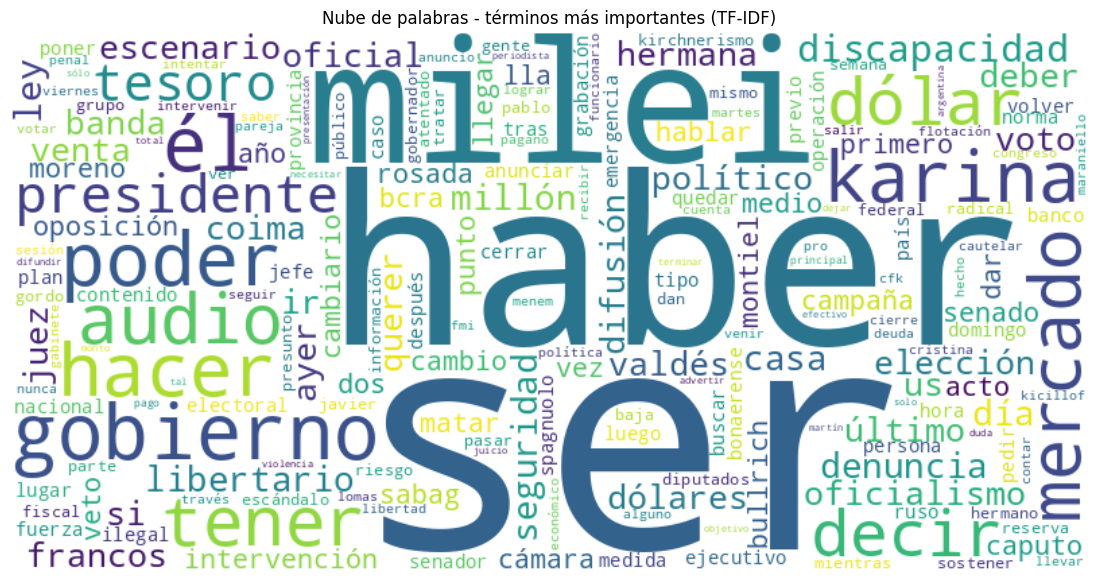

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tenés:
# matriz_tfidf (documento-término)
# vocabulario (lista de términos)

# Sumamos TF-IDF por término para obtener importancia global
importancias = np.array(matriz_tfidf.sum(axis=0)).flatten()

# Creamos un diccionario {palabra: importancia}
frecuencias = dict(zip(vocabulario, importancias))

# Generar nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frecuencias)

# Mostrar
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nube de palabras - términos más importantes (TF-IDF)")
plt.show()


- Gráfico de barras con términos más frecuentes

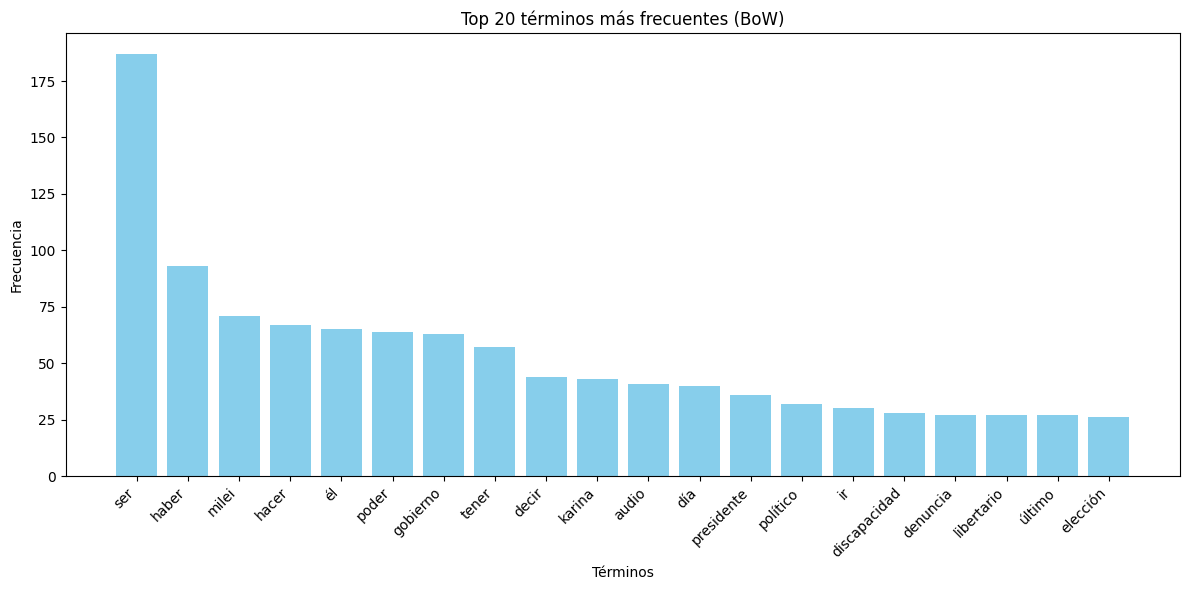

In [ ]:
import matplotlib.pyplot as plt

# Ya tenés la lista top_20 con (palabra, frecuencia)
palabras = [p for p, f in top_20]
frecuencias = [f for p, f in top_20]

plt.figure(figsize=(12,6))
plt.bar(palabras, frecuencias, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel("Términos")
plt.ylabel("Frecuencia")
plt.title("Top 20 términos más frecuentes (BoW)")
plt.tight_layout()
plt.show()


- Heatmap de similitud entre documentos (si no son demasiados)

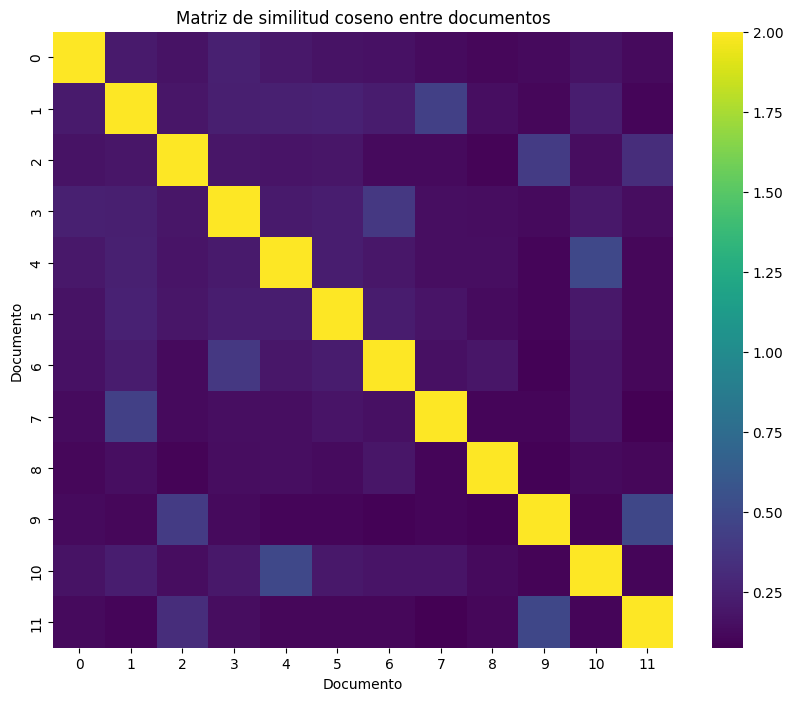

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(matriz_similitud, cmap='viridis')
plt.title("Matriz de similitud coseno entre documentos")
plt.xlabel("Documento")
plt.ylabel("Documento")
plt.show()


### 3.5 Interpretación de resultados

- ¿Qué patrones encontrás en tu corpus?

- ¿Los documentos similares realmente parecen similares?

- ¿Hay agrupaciones naturales en tus datos?

- ¿Qué limitaciones ves en este enfoque?

## Sección 4: Análisis con Word Embeddings (25% de la nota)

In [ ]:
import spacy
!python -m spacy download es_core_news_md
# Cargar modelo en español
nlp = spacy.load("es_core_news_md")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 25.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### 4.1 Aplicación de embeddings

- Procesar tu corpus con spaCy

In [ ]:
# Suponiendo textos_para_vectorizar es una lista de strings (documentos ya limpios)
document_vectors = []

for texto in textos_para_vectorizar:
    doc = nlp(texto)
    # Tomamos el vector promedio del documento completo
    document_vectors.append(doc.vector)


- Obtener vectores para documentos (promedio de vectores de palabras)

In [ ]:
import numpy as np

matriz_vectores = np.array(document_vectors)
print("Forma de la matriz de vectores:", matriz_vectores.shape)


Forma de la matriz de vectores: (12, 300)


- Explicar qué son los embeddings y por qué son diferentes a BoW

✅ ¿Por qué usar embeddings?

Son más compactos y eficientes que BoW.

Mejoran el rendimiento en tareas como clasificación, clustering o similitud.

Permiten hacer operaciones semánticas con vectores.

### 4.2 Análisis de similitud semántica

- Calcular similitud entre documentos usando embeddings

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcula la similitud coseno entre todos los pares de documentos
matriz_similitud_embeddings = cosine_similarity(matriz_vectores)


In [ ]:
print("Matriz de similitud entre documentos (con embeddings):")
print(matriz_similitud_embeddings)


Matriz de similitud entre documentos (con embeddings):
[[1.0000001  0.97593236 0.941282   0.9743741  0.94979423 0.9714214
  0.9651962  0.899783   0.9226921  0.8661529  0.9537255  0.80569434]
 [0.97593236 0.9999995  0.9532189  0.95521355 0.96495926 0.9661635
  0.95106673 0.95914686 0.9260053  0.8871808  0.9700733  0.8292575 ]
 [0.941282   0.9532189  1.0000002  0.9399577  0.9417975  0.94113874
  0.93820363 0.90253794 0.93213516 0.9668794  0.9489113  0.93063384]
 [0.9743741  0.95521355 0.9399577  1.         0.919516   0.9740406
  0.9836328  0.8668948  0.9303539  0.86762375 0.9304713  0.8148022 ]
 [0.94979423 0.96495926 0.9417975  0.919516   0.9999998  0.94057935
  0.9321058  0.9371732  0.93502337 0.8808006  0.99133015 0.83680815]
 [0.9714214  0.9661635  0.94113874 0.9740406  0.94057935 1.0000006
  0.9774417  0.8998161  0.9489391  0.8615568  0.94932675 0.81193376]
 [0.9651962  0.95106673 0.93820363 0.9836328  0.9321058  0.9774417
  1.0000001  0.87586474 0.9592567  0.8631163  0.94145846 0.8

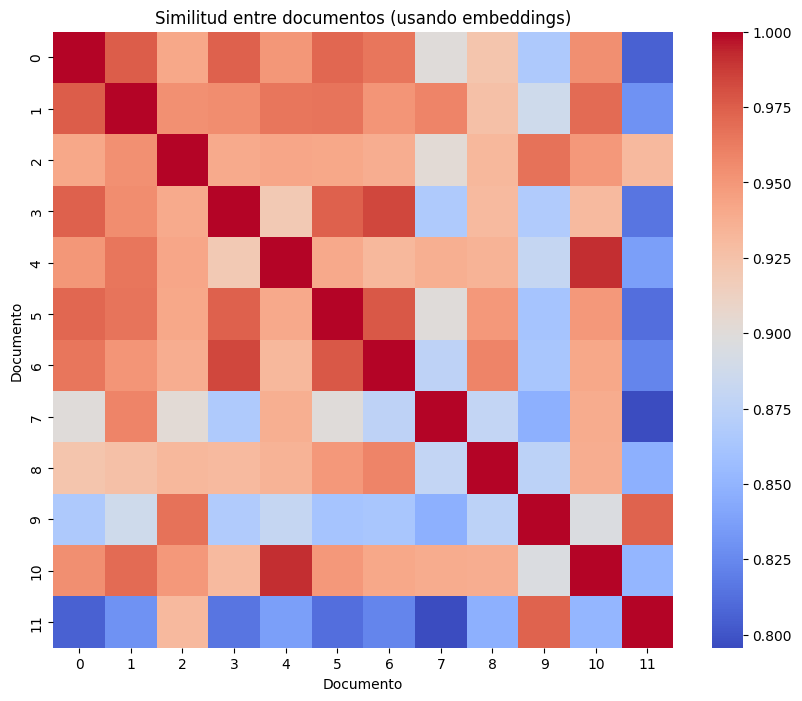

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(matriz_similitud_embeddings, cmap='coolwarm')
plt.title("Similitud entre documentos (usando embeddings)")
plt.xlabel("Documento")
plt.ylabel("Documento")
plt.show()


- Comparar con resultados de TF-IDF

In [ ]:
import numpy as np

def top_pares_similares(matriz, top_n=3):
    np.fill_diagonal(matriz, -1)  # para no contar la diagonal (similitud consigo mismo)
    n = matriz.shape[0]
    flat_indices = np.argpartition(matriz.flatten(), -top_n)[-top_n:]
    pares = [(i // n, i % n) for i in flat_indices]
    return sorted(pares, key=lambda x: matriz[x[0], x[1]], reverse=True)

top_tfidf = top_pares_similares(matriz_similitud)
top_emb = top_pares_similares(matriz_similitud_embeddings)

print("Top pares similares con TF-IDF:")
for i, (a, b) in enumerate(top_tfidf, 1):
    print(f"{i}. Doc {a} y {b} → Similitud: {matriz_similitud[a, b]:.4f}")

print("\nTop pares similares con embeddings:")
for i, (a, b) in enumerate(top_emb, 1):
    print(f"{i}. Doc {a} y {b} → Similitud: {matriz_similitud_embeddings[a, b]:.4f}")


Top pares similares con TF-IDF:
1. Doc 10 y 4 → Similitud: 0.4941
2. Doc 4 y 10 → Similitud: 0.4941
3. Doc 11 y 9 → Similitud: 0.4834

Top pares similares con embeddings:
1. Doc 10 y 4 → Similitud: 0.9913
2. Doc 4 y 10 → Similitud: 0.9913
3. Doc 6 y 3 → Similitud: 0.9836


- ¿Qué documentos son más similares según embeddings?

- ¿Coinciden los resultados con TF-IDF?

### 4.3 Búsqueda de analogías relevantes al corpus

- Encontrar palabras más similares a términos clave de tu dominio

- Intentar crear 2-3 analogías que funcionen con vocabulario de tu corpus

- Ejemplo: "rock es a guitarra como tango es a ?"

- Interpretar: ¿las analogías tienen sentido?

### 4.4 Comparación con resultados de BoW

- Crear tabla comparativa de documentos más similares

In [ ]:
import numpy as np

def obtener_pares_similares(matriz, top_n=3):
    np.fill_diagonal(matriz, -1)  # ignorar la diagonal (autocomparación)
    n = matriz.shape[0]
    flat_indices = np.argpartition(matriz.flatten(), -top_n)[-top_n:]
    pares = [(i // n, i % n) for i in flat_indices]
    pares_ordenados = sorted(pares, key=lambda x: matriz[x[0], x[1]], reverse=True)
    return [(a, b, matriz[a, b]) for a, b in pares_ordenados]


In [ ]:
top_tfidf = obtener_pares_similares(matriz_similitud, top_n=3)
top_emb = obtener_pares_similares(matriz_similitud_embeddings, top_n=3)


In [ ]:
import pandas as pd

# Convertir listas a DataFrames
df_tfidf = pd.DataFrame(top_tfidf, columns=["Doc1", "Doc2", "Similitud_TFIDF"])
df_emb = pd.DataFrame(top_emb, columns=["Doc1", "Doc2", "Similitud_Embeddings"])

# Agregar columna de método
df_tfidf["Método"] = "TF-IDF"
df_emb["Método"] = "Embeddings"

# Combinar en una sola tabla
tabla_comparativa = pd.concat([df_tfidf, df_emb], ignore_index=True)

# Mostrar
print(tabla_comparativa)


   Doc1  Doc2  Similitud_TFIDF      Método  Similitud_Embeddings
0    10     4         0.494101      TF-IDF                   NaN
1     4    10         0.494101      TF-IDF                   NaN
2    11     9         0.483408      TF-IDF                   NaN
3    10     4              NaN  Embeddings              0.991330
4     4    10              NaN  Embeddings              0.991330
5     6     3              NaN  Embeddings              0.983633


- ¿Qué método da resultados más intuitivos?

- ¿En qué casos embeddings es claramente superior?

- ¿En qué casos BoW podría ser suficiente?

### 4.5 Visualización de embeddings (si es posible)

- Intentar reducir dimensionalidad (PCA o t-SNE)

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que embedding_docs es una lista de vectores numpy (n_doc x n_features)
X = np.array(matriz_similitud_embeddings)  # Convertir a numpy array

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)


- Graficar documentos en 2D

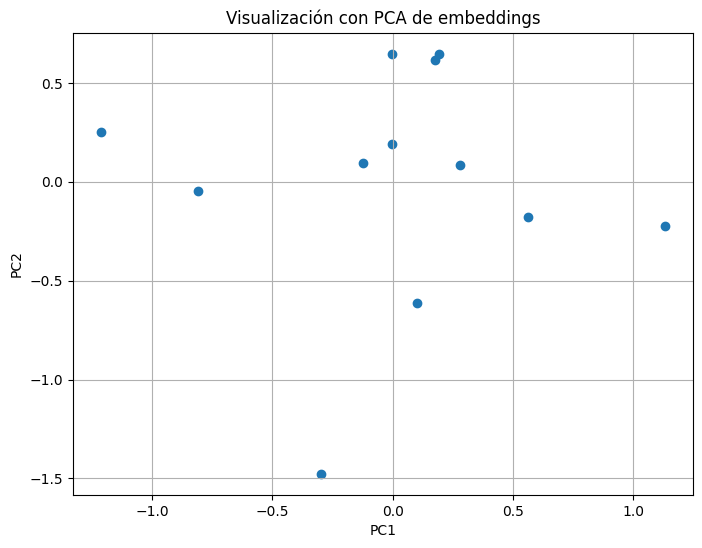

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.title("Visualización con PCA de embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

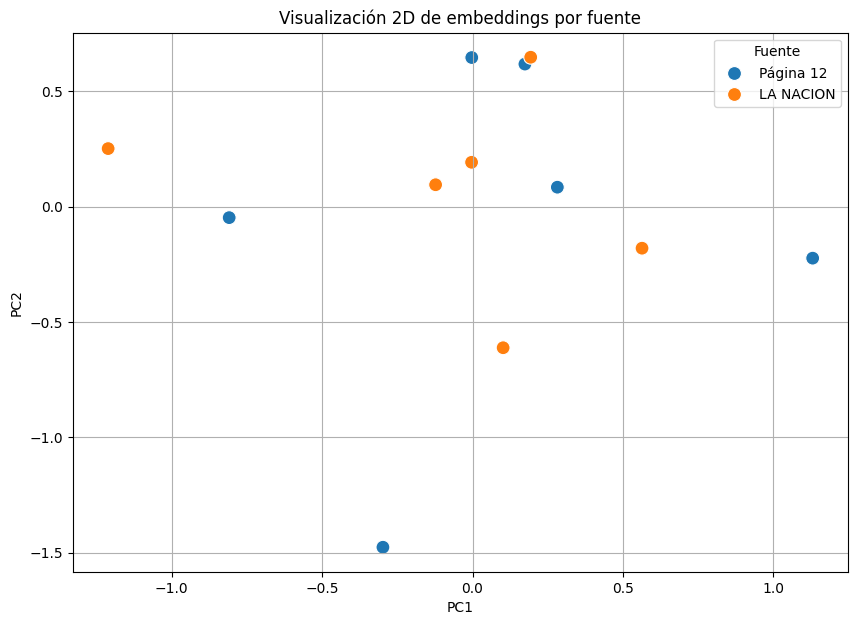

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


df_plot = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
df_plot["fuente"] = df_completo["fuente"].values


plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="fuente", s=100)
plt.title("Visualización 2D de embeddings por fuente")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend(title="Fuente")
plt.show()


- ¿Se ven agrupaciones naturales?

No

## Sección 5: Análisis Complementario

### Opción A: POS Tagging y Análisis Gramatical

In [ ]:
# - Analizar distribución de tipos de palabras (sustantivos, verbos, adjetivos)
# - ¿Hay diferencias gramaticales entre subcategorías de tu corpus?
# - Interpretación estilística de los patrones encontrados

Distribución promedio de POS por fuente:

                  ADP        NOUN      SPACE        NUM        ADV      SCONJ  \
fuente                                                                          
LA NACION  201.833333  239.666667  16.666667  18.500000  32.333333  22.333333   
Página 12  283.666667  339.333333  19.833333  22.166667  56.333333  43.666667   

                 VERB       PUNCT         DET       PROPN       PRON  \
fuente                                                                 
LA NACION  117.000000  165.500000  172.166667   94.666667  44.666667   
Página 12  181.833333  224.833333  238.000000  153.833333  96.166667   

               CCONJ        ADJ        AUX      PART       SYM      INTJ  
fuente                                                                    
LA NACION  33.833333  81.333333  25.666667  0.333333  4.666667  0.500000  
Página 12  49.500000  98.000000  44.500000  0.833333  0.666667  0.333333  


<Figure size 1200x600 with 0 Axes>

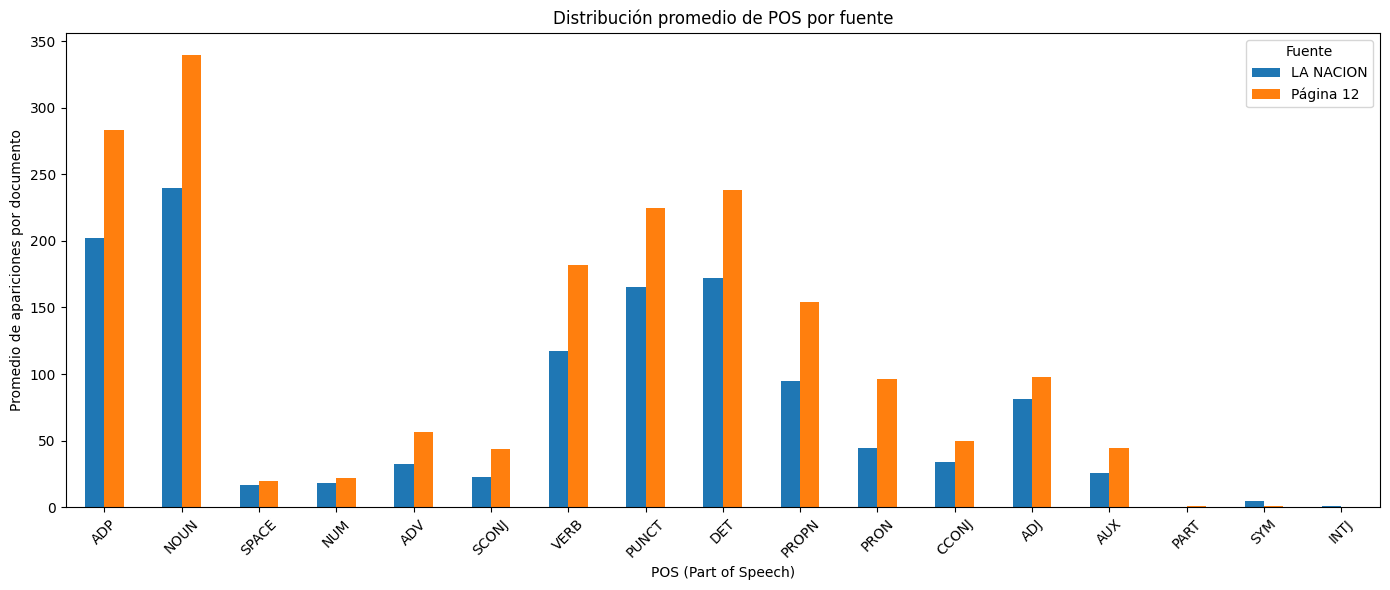

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy

# Cargar modelo spaCy
nlp = spacy.load("es_core_news_md")

# Función para obtener distribución POS de un texto
def distribucion_pos(texto):
    """
    Recibe un texto (lista de tokens limpios o string) y devuelve conteo de POS.
    """
    if isinstance(texto, list):
        texto = " ".join(texto)
    doc = nlp(texto)
    pos_counts = {}
    for token in doc:
        pos = token.pos_
        pos_counts[pos] = pos_counts.get(pos, 0) + 1
    return pos_counts

# Calcular distribución POS por documento
pos_por_doc = {
    idx: distribucion_pos(row["parrafos"])
    for idx, row in df_completo.iterrows()
}

# Convertir a DataFrame
df_pos = pd.DataFrame(pos_por_doc).T  # cada fila = documento
df_pos.fillna(0, inplace=True)

# Agregar columna con "fuente"
df_pos["fuente"] = df_completo["fuente"].values

# Agrupar por fuente y promediar
df_pos_fuente = df_pos.groupby("fuente").mean(numeric_only=True)

# Mostrar resultados
print("Distribución promedio de POS por fuente:\n")
print(df_pos_fuente)

# Graficar
plt.figure(figsize=(12, 6))
df_pos_fuente.T.plot(kind='bar', figsize=(14, 6))
plt.title("Distribución promedio de POS por fuente")
plt.xlabel("POS (Part of Speech)")
plt.ylabel("Promedio de apariciones por documento")
plt.xticks(rotation=45)
plt.legend(title="Fuente")
plt.tight_layout()
plt.show()


In [ ]:
df_pos_normalizado = df_pos.drop(columns="fuente").div(df_pos.drop(columns="fuente").sum(axis=1), axis=0)
df_pos_normalizado["fuente"] = df_pos["fuente"]
df_pos_fuente_normalizado = df_pos_normalizado.groupby("fuente").mean()


<Figure size 1400x600 with 0 Axes>

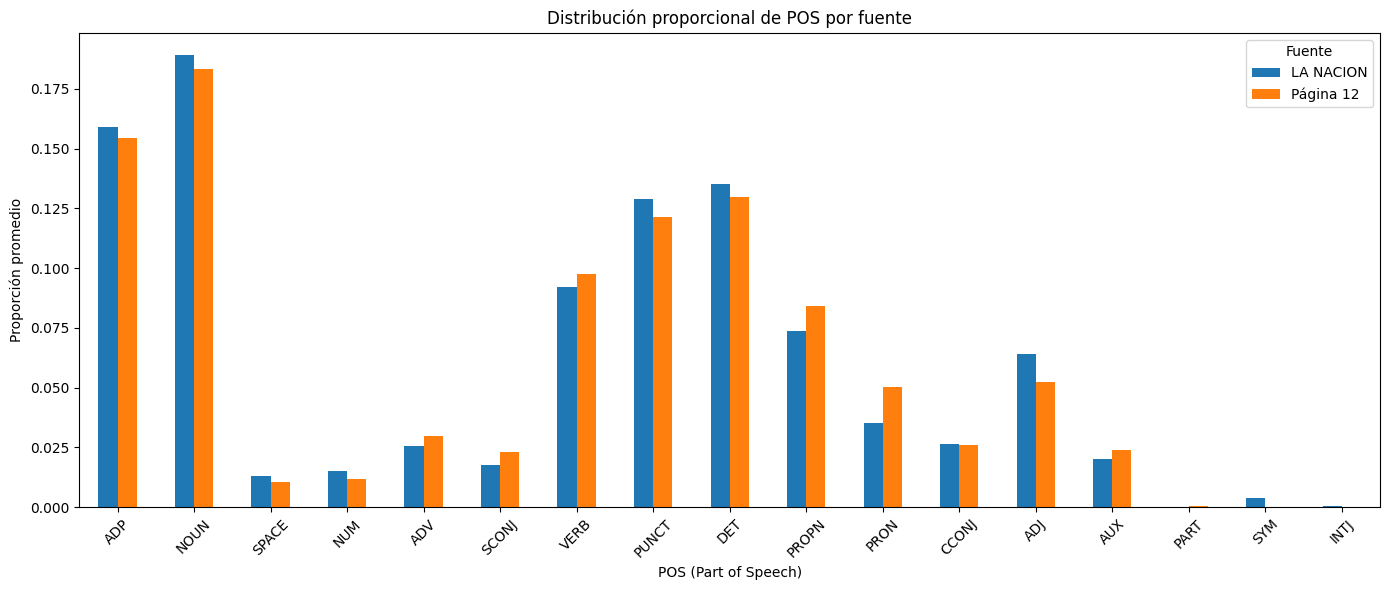

In [ ]:
plt.figure(figsize=(14, 6))
df_pos_fuente_normalizado.T.plot(kind='bar', figsize=(14, 6))
plt.title("Distribución proporcional de POS por fuente")
plt.xlabel("POS (Part of Speech)")
plt.ylabel("Proporción promedio")
plt.xticks(rotation=45)
plt.legend(title="Fuente")
plt.tight_layout()
plt.show()


In [16]:
def extraer_entidades(texto):
    doc = nlp(texto)
    entidades = [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['PER', 'ORG']]
    return entidades
def oraciones_por_entidad(texto):
    doc = nlp(texto)
    oraciones = list(doc.sents)

    entidad_oraciones = {}

    for oracion in oraciones:
        entidades_en_oracion = [ent.text for ent in oracion.ents if ent.label_ in ['PER', 'ORG']]
        for ent in entidades_en_oracion:
            entidad_oraciones.setdefault(ent, []).append(oracion.text)

    return entidad_oraciones


In [25]:
from collections import Counter

def contar_entidades(texto):
    doc = nlp(texto)
    entidades = [ent.text for ent in doc.ents if ent.label_ in ['PER', 'ORG']]
    return entidades

# Por ejemplo, para todo un conjunto de textos:
todas_entidades = []

for texto in df_completo['parrafos_limpios']:
    todas_entidades.extend(contar_entidades(texto))

frecuencias = Counter(todas_entidades)
print(frecuencias.most_common(10))  # Las 10 entidades más mencionadas

[('karina milei', 26), ('karina', 13), ('javier milei', 10), ('fmi', 9), ('llegó', 6), ('patricia bullrich', 6), ('menem', 6), ('cristina', 5), ('axel kicillof', 5), ('diego', 3)]


In [30]:
top_10 = frecuencias.most_common(30)

# Paso 5: Limpiar nombres de entidades (quitar saltos de línea, etc.)
frecuencias_top_10 = {
    k.replace('\n', ' ').replace('\r', '').strip(): v
    for k, v in top_10
}

print("Top 10 entidades más comunes:")
for entidad, frecuencia in frecuencias_top_10.items():
    print(f"{entidad}: {frecuencia}")

Top 10 entidades más comunes:
karina milei: 26
karina: 13
javier milei: 10
fmi: 9
llegó: 6
patricia bullrich: 6
menem: 6
cristina: 5
axel kicillof: 5
diego: 3
pablo: 3
mauricio macri: 3
agregó: 3
francisco paoltroni: 3
franco: 3
juan pablo: 3
cristina fernández: 2
kirchner: 2
fondo monetario internacional: 2
fernando: 2
habían: 2
julián ercolini: 2
carlos stornelli: 2
andis: 2
discapacidad andis: 2
luis juez: 2
alejandro patricio maraniello: 2
jorge rial: 2
federico de pablo: 2
ricardo colombi: 2


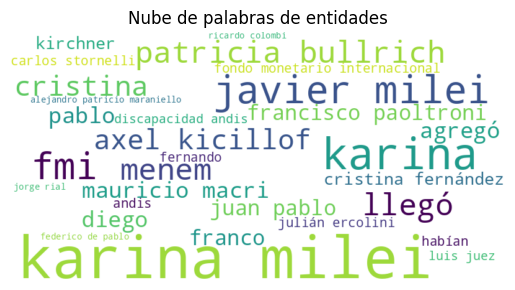

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# crear nube con las frecuencias
nube = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(frecuencias_top_10)

plt.imshow(nube, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras de entidades')
plt.show()


## Sección 6: Conclusiones y Reflexiones

In [ ]:
# 6.1 Hallazgos principales sobre el corpus
# - ¿Qué descubriste sobre tu corpus que no sabías antes?
# - ¿Se confirmaron tus hipótesis iniciales?
# - ¿Qué te sorprendió más?

# 6.2 Comparación de métodos utilizados
# - ¿Qué técnica te pareció más útil para tu tipo de corpus?
# - ¿Cuándo usarías BoW/TF-IDF vs embeddings?
# - ¿Qué ventajas y desventajas encontraste en cada método?

# 6.3 Limitaciones encontradas
# - ¿Qué no pudiste capturar con las técnicas usadas?
# - ¿Qué aspectos importantes de tu corpus quedan sin analizar?
# - ¿Qué mejorarías si tuvieras más tiempo/recursos?

# 6.4 Aplicaciones potenciales del análisis
# - ¿Cómo se podría usar este análisis en un contexto real?
# - ¿Qué valor agregado proporciona?
# - ¿Qué otros análisis te gustaría hacer en el futuro?